In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from dash import Dash, dcc, html, Input, Output, callback, ctx
import plotly.express as px
import numpy as np
import pandas as pd
import datetime
import json
from datetime import datetime as dt
import pathlib
import plotly.graph_objects as go 
import plotly.io as pio
import dash_bootstrap_components as dbc

import plotly.express as px


In [3]:
#!pip3 install nbformat

# TRABAJO FINAL
## Historia

El Dasboard que se presenta corresponde al Total de Ventas y Compras del 2024 obtenidas del registro de Dato Abierto del SRI

**Fuente:** SRI - Dato abierto
**Conjunto de datos:** compra y ventas 2024

### Tratamiento de la información:

    1.⁠ ⁠Eliminación de registros con código de actividad diferente a letras (9 registros)
    2.⁠ ⁠Eliminación de registros cuya provincia sea ND (1 registro)
    3.⁠ ⁠Creación de las columnas de:
    a. Descripción actividad económica
    b. Latitud y Longitud de los cantones del Ecuador
    c. Población del cantón
    d. Calculo de total de ventas y total de compras
    e. Impuesto generado 12% (enero a marzo)
    f. Impuesto generado 15% (abril a julio)

### Dashboard:

    1.⁠ ⁠Se organiza el Dashboard por región del Ecuador; un tab por región
    2.⁠ ⁠Los filtros identificados son mes y actividad económica a nivel 1
    3.⁠ ⁠Muestra el mapa del Ecuador y en cada región resalta sus provincias 
    4.⁠ ⁠En los gráficos de barras se observa el Total de ventas y compras para tarifa 0 y tarifa gravada IVA por Cantón en el mes seleccionado.
    4.⁠ ⁠Finalmente muestra el total de impuesto generado por compras y ventas para los cantones de la región en la que se encuentre ubicado.

### Conclusión

En el trabajo práctico se han aplicado todos los conceptos vistos en la materia de Visualización avanzada para Data Science, desde las graficas estáticas hasta la construcción de un Dashboard que cuente una historia fácil de entender.
Para el grupo ha sido un reto poder cumplir y entender todos los conceptos vistos y aplicarlos de manera práctica con datos reales.


In [4]:
df = pd.read_csv('../dash-clinical-analytics_est/sri_ventas_2024.csv', encoding='latin-1', sep='|')

In [5]:
numericas = [
    'VENTAS_NETAS_TARIFA_12',
    'VENTAS_NETAS_TARIFA_0',
    'EXPORTACIONES',
    'COMPRAS_NETAS_TARIFA_12',
    'COMPRAS_NETAS_TARIFA_0',
    'IMPORTACIONES',
    'COMPRAS_RISE',
    'TOTAL_COMPRAS',
    'TOTAL_VENTAS'
]

for col in numericas:
    df[col] = df[col].replace({'': '0'})  # Reemplazar cadenas vacías por '0'
    df[col] = df[col].str.replace(',', '.').astype(float)


In [6]:
df = df[~df['CODIGO_SECTOR_N1'].isin(['V', 'X', 'W', '9'])]
df = df[df['PROVINCIA'] != 'ND']
df = df.drop(['TOTAL_COMPRAS', 'TOTAL_VENTAS'], axis=1)
df['TOTAL_COMPRAS'] = df['COMPRAS_NETAS_TARIFA_12'] + df['COMPRAS_NETAS_TARIFA_0'] + df['IMPORTACIONES'] + df['COMPRAS_RISE']
df['TOTAL_VENTAS'] = df['VENTAS_NETAS_TARIFA_12'] + df['VENTAS_NETAS_TARIFA_0'] + df['EXPORTACIONES']

#Bases
df['BASE_IMPONIBLE_VENTAS'] = df.apply(
    lambda row: row['VENTAS_NETAS_TARIFA_12'] / 1.12 if row['MES'] in [1, 2, 3] else
                 row['VENTAS_NETAS_TARIFA_12'] / 1.15,
    axis=1
)

df['IMPUESTO_VENTAS'] = df['VENTAS_NETAS_TARIFA_12'] - df['BASE_IMPONIBLE_VENTAS']

#Bases
df['BASE_IMPONIBLE_COMPRAS'] = df.apply(
    lambda row: row['COMPRAS_NETAS_TARIFA_12'] / 1.12 if row['MES'] in [1, 2, 3] else
                 row['COMPRAS_NETAS_TARIFA_12'] / 1.15,
    axis=1
)

df['IMPUESTO_COMPRAS'] = df['COMPRAS_NETAS_TARIFA_12'] - df['BASE_IMPONIBLE_COMPRAS']

In [7]:
df.head(10)

,AÑO,MES,CODIGO_SECTOR_N1,PROVINCIA,CANTON,VENTAS_NETAS_TARIFA_12,VENTAS_NETAS_TARIFA_0,EXPORTACIONES,COMPRAS_NETAS_TARIFA_12,COMPRAS_NETAS_TARIFA_0,IMPORTACIONES,COMPRAS_RISE,TOTAL_COMPRAS,TOTAL_VENTAS,BASE_IMPONIBLE_VENTAS,IMPUESTO_VENTAS,BASE_IMPONIBLE_COMPRAS,IMPUESTO_COMPRAS
0,2024,1,G,GALAPAGOS,ISABELA,116567.25,94589.94,0.00,203759.54,80978.61,0.00,720.00,2.854582e+05,2.111572e+05,1.040779e+05,1.248935e+04,1.819282e+05,2.183138e+04
1,2024,1,S,MANABI,PORTOVIEJO,840182.10,1432183.33,0.00,969367.30,876986.80,2888.98,64608.48,1.913852e+06,2.272365e+06,7.501626e+05,9.001951e+04,8.655065e+05,1.038608e+05
2,2024,1,Q,EL ORO,EL GUABO,674.34,37748.72,0.00,26912.00,41877.56,0.00,710.05,6.949961e+04,3.842306e+04,6.020893e+02,7.225071e+01,2.402857e+04,2.883429e+03
3,2024,2,M,CARCHI,MIRA,24522.42,3243.59,0.00,22825.50,2524.46,0.00,0.00,2.534996e+04,2.776601e+04,2.189502e+04,2.627402e+03,2.037991e+04,2.445589e+03
4,2024,2,F,LOJA,MACARA,926.04,0.00,0.00,10512.41,128.03,0.00,0.00,1.064044e+04,9.260400e+02,8.268214e+02,9.921857e+01,9.386080e+03,1.126330e+03
5,2024,2,G,GUAYAS,MILAGRO,13924559.70,25750620.77,1741475.36,13179228.89,12931019.79,322658.55,123519.55,2.655643e+07,4.141666e+07,1.243264e+07,1.491917e+06,1.176717e+07,1.412060e+06
6,2024,2,G,GUAYAS,DURAN,28652576.29,44141066.17,74266406.41,23825339.53,87879591.82,24186302.13,556309.01,1.364475e+08,1.470600e+08,2.558266e+07,3.069919e+06,2.127262e+07,2.552715e+06
7,2024,2,M,AZUAY,CUENCA,24373567.71,2263487.12,349921.59,12959129.93,2166199.07,476383.77,402186.54,1.600390e+07,2.698698e+07,2.176211e+07,2.611454e+06,1.157065e+07,1.388478e+06
8,2024,2,I,GUAYAS,GUAYAQUIL,45894639.89,4424483.28,102999.24,21477517.07,11489529.00,731733.62,737209.61,3.443599e+07,5.042212e+07,4.097736e+07,4.917283e+06,1.917635e+07,2.301163e+06
9,2024,1,S,GUAYAS,EL EMPALME,37568.55,157517.61,0.00,43366.34,96104.38,22.85,640.30,1.401339e+05,1.950862e+05,3.354335e+04,4.025202e+03,3.871995e+04,4.646394e+03


In [8]:
provincias = {
    'AZUAY': 1, 'BOLIVAR': 2, 'CAÑAR': 3, 'CARCHI': 4, 'CHIMBORAZO': 5,
    'COTOPAXI': 6, 'EL ORO': 7, 'ESMERALDAS': 8, 'GALAPAGOS': 9,
    'GUAYAS': 10, 'IMBABURA': 11, 'LOJA': 12, 'LOS RIOS': 13,
    'MANABI': 14, 'MORONA SANTIAGO': 15, 'NAPO': 16, 'ORELLANA': 17,
    'PASTAZA': 18, 'PICHINCHA': 19, 'SANTA ELENA': 20,
    'SANTO DOMINGO DE LOS TSACHILAS': 21, 'SUCUMBIOS': 22,
    'TUNGURAHUA': 23, 'ZAMORA CHINCHIPE': 24
}

df['COD_PROVINCIA'] = df['PROVINCIA'].map(provincias).astype(int)

In [9]:
capitales = {
    "provincia": ["Azuay", "Bolivar", "Cañar", "Carchi", "Chimborazo",
                  "Cotopaxi", "El Oro", "Esmeraldas", "Galapagos",
                  "Guayas", "Imbabura", "Loja", "Los Rios", "Manabi",
                  "Morona Santiago", "Napo", "Orellana", "Pastaza",
                  "Pichincha", "Santa Elena", "Santo Domingo de los Tsachilas",
                  "Sucumbios", "Tungurahua", "Zamora Chinchipe"],
    "codigoProv": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                   11, 12, 13, 14, 15, 16, 17, 18,
                   19, 20, 21, 22, 23, 24],
    "longitud": [-79.0045300, -79.0009800, -78.8486000, -77.7172700, -78.6471200,
                 -78.6155400, -79.9605300, -79.6539700, -89.608586,
                 -79.9079500, -78.1223300, -79.2042200, -79.5344300,
                 -80.4544500, -78.1113500, -77.8128600, -75.666667,
                 -78.0025700, -78.5249500, -80.8587300, -79.1753600,
                 -76.883333, -78.6167500, -78.9469500],
    "latitud": [-2.9005500, -1.5926300, -2.7396900, 0.8118700, -1.6709800,
                -0.9352100, -3.2586100, 0.9592000, -0.902486,
                -2.2058400, 0.3517100, -3.9931300, -1.8021700,
                -1.0545800, -2.3086800, -0.9938000, -0.933333,
                -1.4836900, -0.2298500, -2.2262200, -0.2530500,
                -0.083333, -1.2490800, -4.0692100],
    "habitantes": ["712127", "183641", "225184", "164524", "458581",
               "409205", "600659", "534092", "25124",
               "3645483", "398244", "448966", "778115",
               "1369780", "147940", "103697", "136396",
               "83933", "2576287", "308693", "368013",
               "176472", "504583", "91376"],
    "region": ["Sierra", "Sierra", "Sierra", "Sierra", "Sierra",
               "Sierra", "Costa", "Costa", "Costa",
               "Costa", "Sierra", "Sierra", "Costa",
               "Costa", "Amazonía", "Amazonía", "Amazonía",
               "Amazonía", "Sierra", "Costa",
               "Sierra", "Amazonía", "Sierra", "Amazonía"]
}

dfCapitales = pd.DataFrame(capitales)

In [10]:
actividades = {
    'codigoActividad': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
               'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U'],
    'descripcion': [
        'AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA.',
        'EXPLOTACIÓN DE MINAS Y CANTERAS.',
        'INDUSTRIAS MANUFACTURERAS.',
        'SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ACONDICIONADO.',
        'DISTRIBUCIÓN DE AGUA; ALCANTARILLADO, GESTIÓN DE DESECHOS Y ACTIVIDADES DE SANEAMIENTO.',
        'CONSTRUCCIÓN.',
        'COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS.',
        'TRANSPORTE Y ALMACENAMIENTO.',
        'ACTIVIDADES DE ALOJAMIENTO Y DE SERVICIO DE COMIDAS.',
        'INFORMACIÓN Y COMUNICACIÓN.',
        'ACTIVIDADES FINANCIERAS Y DE SEGUROS.',
        'ACTIVIDADES INMOBILIARIAS.',
        'ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS.',
        'ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE APOYO.',
        'ADMINISTRACIÓN PÚBLICA Y DEFENSA; PLANES DE SEGURIDAD SOCIAL DE AFILIACIÓN OBLIGATORIA.',
        'ENSEÑANZA.',
        'ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL.',
        'ARTES, ENTRETENIMIENTO Y RECREACIÓN.',
        'OTRAS ACTIVIDADES DE SERVICIOS.',
        'ACTIVIDADES DE LOS HOGARES COMO EMPLEADORES; ACTIVIDADES NO DIFERENCIADAS DE LOS HOGARES COMO PRODUCTORES DE BIENES Y SERVICIOS PARA USO PROPIO.',
        'ACTIVIDADES DE ORGANIZACIONES Y ÓRGANOS EXTRATERRITORIALES.'
    ]
}

dfActividades = pd.DataFrame(actividades)

In [11]:
df = df.merge(dfCapitales, how='left', left_on='COD_PROVINCIA', right_on='codigoProv')
df = df.merge(dfActividades, how='left', left_on='CODIGO_SECTOR_N1', right_on='codigoActividad')
df = df.drop(['CODIGO_SECTOR_N1', 'provincia','codigoProv', 'codigoActividad'], axis=1)

In [12]:
df.head(10)

,AÑO,MES,PROVINCIA,CANTON,VENTAS_NETAS_TARIFA_12,VENTAS_NETAS_TARIFA_0,EXPORTACIONES,COMPRAS_NETAS_TARIFA_12,COMPRAS_NETAS_TARIFA_0,IMPORTACIONES,...,BASE_IMPONIBLE_VENTAS,IMPUESTO_VENTAS,BASE_IMPONIBLE_COMPRAS,IMPUESTO_COMPRAS,COD_PROVINCIA,longitud,latitud,habitantes,region,descripcion
0,2024,1,GALAPAGOS,ISABELA,116567.25,94589.94,0.00,203759.54,80978.61,0.00,...,1.040779e+05,1.248935e+04,1.819282e+05,2.183138e+04,9,-89.608586,-0.902486,25124,Costa,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...
1,2024,1,MANABI,PORTOVIEJO,840182.10,1432183.33,0.00,969367.30,876986.80,2888.98,...,7.501626e+05,9.001951e+04,8.655065e+05,1.038608e+05,14,-80.454450,-1.054580,1369780,Costa,OTRAS ACTIVIDADES DE SERVICIOS.
2,2024,1,EL ORO,EL GUABO,674.34,37748.72,0.00,26912.00,41877.56,0.00,...,6.020893e+02,7.225071e+01,2.402857e+04,2.883429e+03,7,-79.960530,-3.258610,600659,Costa,ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y D...
3,2024,2,CARCHI,MIRA,24522.42,3243.59,0.00,22825.50,2524.46,0.00,...,2.189502e+04,2.627402e+03,2.037991e+04,2.445589e+03,4,-77.717270,0.811870,164524,Sierra,"ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNI..."
4,2024,2,LOJA,MACARA,926.04,0.00,0.00,10512.41,128.03,0.00,...,8.268214e+02,9.921857e+01,9.386080e+03,1.126330e+03,12,-79.204220,-3.993130,448966,Sierra,CONSTRUCCIÓN.
5,2024,2,GUAYAS,MILAGRO,13924559.70,25750620.77,1741475.36,13179228.89,12931019.79,322658.55,...,1.243264e+07,1.491917e+06,1.176717e+07,1.412060e+06,10,-79.907950,-2.205840,3645483,Costa,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...
6,2024,2,GUAYAS,DURAN,28652576.29,44141066.17,74266406.41,23825339.53,87879591.82,24186302.13,...,2.558266e+07,3.069919e+06,2.127262e+07,2.552715e+06,10,-79.907950,-2.205840,3645483,Costa,COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACI...
7,2024,2,AZUAY,CUENCA,24373567.71,2263487.12,349921.59,12959129.93,2166199.07,476383.77,...,2.176211e+07,2.611454e+06,1.157065e+07,1.388478e+06,1,-79.004530,-2.900550,712127,Sierra,"ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNI..."
8,2024,2,GUAYAS,GUAYAQUIL,45894639.89,4424483.28,102999.24,21477517.07,11489529.00,731733.62,...,4.097736e+07,4.917283e+06,1.917635e+07,2.301163e+06,10,-79.907950,-2.205840,3645483,Costa,ACTIVIDADES DE ALOJAMIENTO Y DE SERVICIO DE CO...
9,2024,1,GUAYAS,EL EMPALME,37568.55,157517.61,0.00,43366.34,96104.38,22.85,...,3.354335e+04,4.025202e+03,3.871995e+04,4.646394e+03,10,-79.907950,-2.205840,3645483,Costa,OTRAS ACTIVIDADES DE SERVICIOS.


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27585 entries, 0 to 27584
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AÑO                      27585 non-null  int64  
 1   MES                      27585 non-null  int64  
 2   PROVINCIA                27585 non-null  object 
 3   CANTON                   27585 non-null  object 
 4   VENTAS_NETAS_TARIFA_12   27585 non-null  float64
 5   VENTAS_NETAS_TARIFA_0    27585 non-null  float64
 6   EXPORTACIONES            27585 non-null  float64
 7   COMPRAS_NETAS_TARIFA_12  27585 non-null  float64
 8   COMPRAS_NETAS_TARIFA_0   27585 non-null  float64
 9   IMPORTACIONES            27585 non-null  float64
 10  COMPRAS_RISE             27585 non-null  float64
 11  TOTAL_COMPRAS            27585 non-null  float64
 12  TOTAL_VENTAS             27585 non-null  float64
 13  BASE_IMPONIBLE_VENTAS    27585 non-null  float64
 14  IMPUESTO_VENTAS       

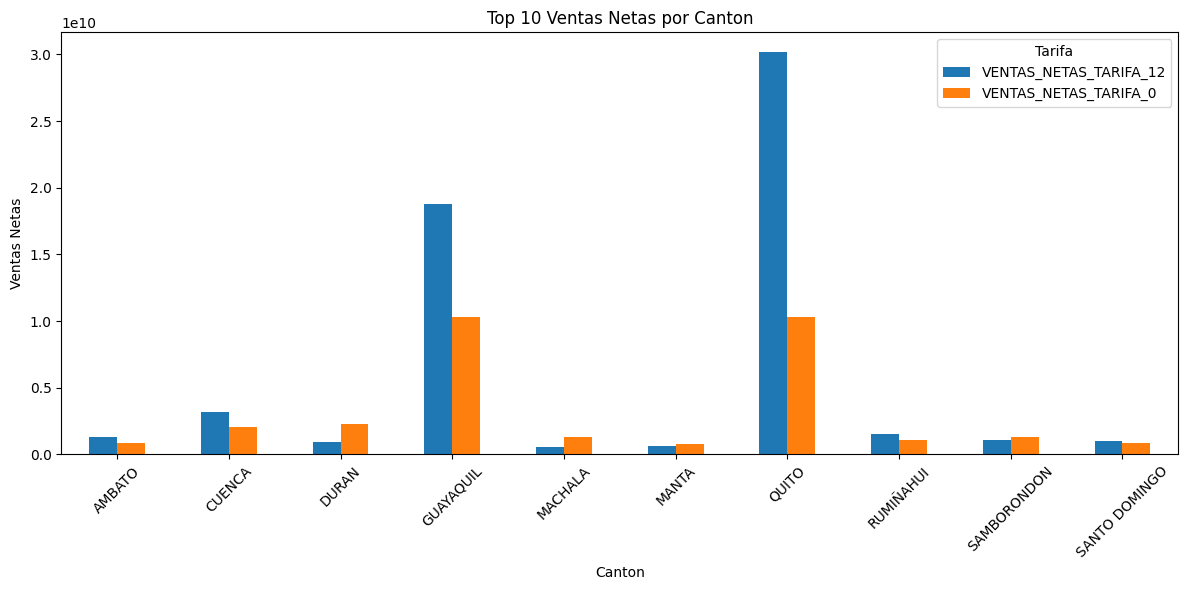

In [14]:
ventas_por_canton = df.groupby('CANTON')[['VENTAS_NETAS_TARIFA_12', 'VENTAS_NETAS_TARIFA_0']].sum()

top_cantones = ventas_por_canton.nlargest(10, 'VENTAS_NETAS_TARIFA_12').index.union(
    ventas_por_canton.nlargest(10, 'VENTAS_NETAS_TARIFA_0').index
)

top_ventas = ventas_por_canton.loc[top_cantones]

# Grafica
top_ventas.plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Ventas Netas por Canton')
plt.xlabel('Canton')
plt.ylabel('Ventas Netas')
plt.xticks(rotation=45)
plt.legend(title='Tarifa')
plt.tight_layout()
plt.show()


In [15]:
ventas_por_canton = df.groupby('CANTON')[['VENTAS_NETAS_TARIFA_12', 'VENTAS_NETAS_TARIFA_0']].sum()
ventas_por_canton

,VENTAS_NETAS_TARIFA_12,VENTAS_NETAS_TARIFA_0
CANTON,,
24 DE MAYO,2.679906e+06,7.220483e+06
AGUARICO,3.210643e+06,3.368450e+06
ALAUSI,7.930413e+06,1.026057e+07
ALFREDO BAQUERIZO MORENO,1.334400e+07,2.188037e+07
AMBATO,1.310013e+09,8.489130e+08
...,...,...
YACUAMBI,8.646369e+05,5.890550e+05
YANTZAZA,8.276365e+07,5.394236e+07
ZAMORA,5.253121e+07,3.592754e+07


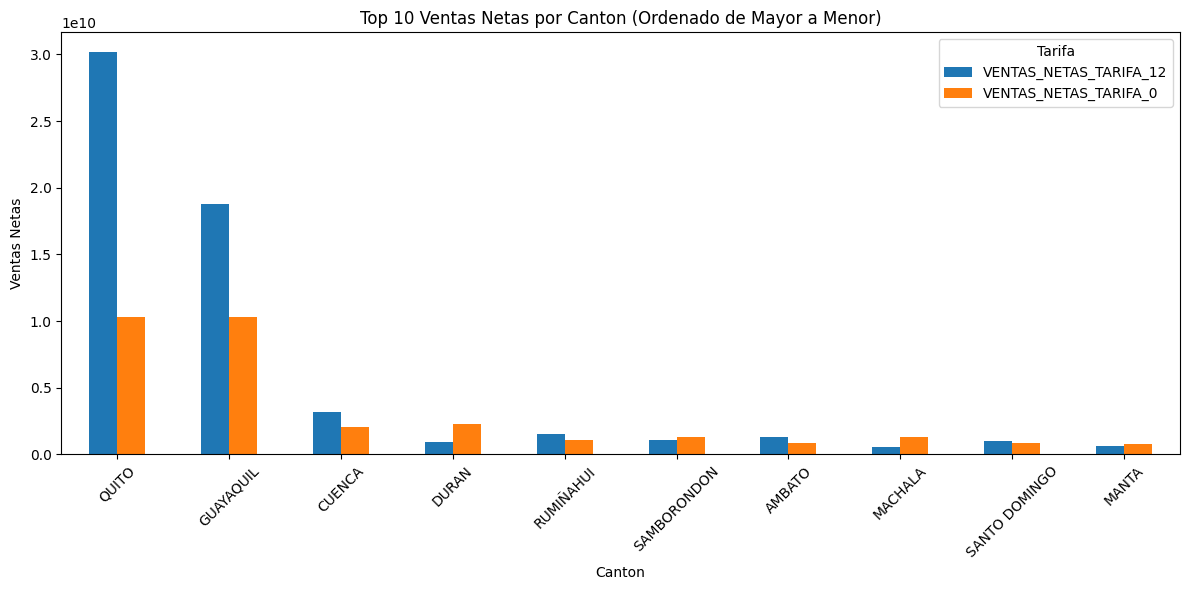

In [16]:
ventas_por_canton = df.groupby('CANTON')[['VENTAS_NETAS_TARIFA_12', 'VENTAS_NETAS_TARIFA_0']].sum()

top_cantones = ventas_por_canton.nlargest(10, 'VENTAS_NETAS_TARIFA_12').index.union(
    ventas_por_canton.nlargest(10, 'VENTAS_NETAS_TARIFA_0').index
)

top_ventas = ventas_por_canton.loc[top_cantones]

top_ventas['TOTAL_VENTAS'] = top_ventas['VENTAS_NETAS_TARIFA_12'] + top_ventas['VENTAS_NETAS_TARIFA_0']
top_ventas = top_ventas.sort_values(by='TOTAL_VENTAS', ascending=False)

top_ventas = top_ventas.drop(columns='TOTAL_VENTAS')

# Graficar
top_ventas.plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Ventas Netas por Canton (Ordenado de Mayor a Menor)')
plt.xlabel('Canton')
plt.ylabel('Ventas Netas')
plt.xticks(rotation=45)
plt.legend(title='Tarifa')
plt.tight_layout()
plt.show()


In [17]:
def tax_month():

    impuestos_por_mes = df.groupby('MES')[['IMPUESTO_VENTAS', 'IMPUESTO_COMPRAS']].sum().reset_index()
    fig = px.line(impuestos_por_mes, 
                x='MES', 
                y=['IMPUESTO_VENTAS', 'IMPUESTO_COMPRAS'],
                markers=True,
                title='Impuestos por Compras y Ventas por Mes',
                labels={'x': 'Mes del Año', 'y': 'Impuestos'},)

    fig.update_layout(xaxis_title='Mes del Año',
                    yaxis_title='Impuestos',
                    width=800, height=500)
    return fig


In [18]:
## Encabezado 
def header_title():
    return html.Div([
            html.H3("DATOS ABIERTOS SRI", style={'textAlign':'center'}),
            html.H3("VENTAS – COMPRAS  2024", style={'textAlign':'center'})
        ], style={'marginBottom': 25, 'marginTop': 25})

In [19]:
## Valores únicos para mes y actividad economica
meses_anio = df["MES"].unique()
descripcion_actividad_ec = df["descripcion"].unique()

In [20]:
def map_ecuator(region):

    df_aux = df.copy()

    df_aux_1 = df_aux[df_aux['region'] == region]

    fig = px.scatter_mapbox(df_aux_1, 
                        hover_name='PROVINCIA',
                        lat="latitud",
                        lon="longitud",
                        zoom=5)

    # Configurar el diseño del mapa
    fig.update_layout(mapbox_style="open-street-map")
    
    return fig
    

In [21]:
def graph_base(region):

    ventas_por_region = df.groupby('CANTON')[['VENTAS_NETAS_TARIFA_12', 'VENTAS_NETAS_TARIFA_0']].sum()

    df_region_ventas = df[df["region"] == region]

    df_region_ventas= df_region_ventas.groupby('CANTON')[['VENTAS_NETAS_TARIFA_12', 'VENTAS_NETAS_TARIFA_0']].sum()

    top_canton_ventas = df_region_ventas.nlargest(10, 'VENTAS_NETAS_TARIFA_12').index.union(
        df_region_ventas.nlargest(10, 'VENTAS_NETAS_TARIFA_0').index
    )
    top_ventas = ventas_por_region.loc[top_canton_ventas]

    top_ventas['TOTAL_VENTAS'] = top_ventas['VENTAS_NETAS_TARIFA_12'] + top_ventas['VENTAS_NETAS_TARIFA_0']
    top_ventas = top_ventas.sort_values(by='TOTAL_VENTAS', ascending=False)
    top_ventas = top_ventas.drop(columns='TOTAL_VENTAS')

    fig = px.bar(top_ventas.reset_index(), 
                 x="CANTON", 
                 y=['VENTAS_NETAS_TARIFA_12', 'VENTAS_NETAS_TARIFA_0'],
                 barmode='group',
                 title='Top Ventas por Cantón',
                 labels={'y': 'Total Ventas'},)
    
    

    fig.update_layout(yaxis_title='Total Ventas',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
    return fig

In [22]:
graph_base('Sierra')

In [23]:
def graph_base_buy(region):

    compras_por_region = df.groupby('CANTON')[['COMPRAS_NETAS_TARIFA_12', 'COMPRAS_NETAS_TARIFA_0']].sum()

    df_region_compras = df[df["region"] == region]

    df_region_compras= df_region_compras.groupby('CANTON')[['COMPRAS_NETAS_TARIFA_12', 'COMPRAS_NETAS_TARIFA_0']].sum()

    top_canton_compras = df_region_compras.nlargest(10, 'COMPRAS_NETAS_TARIFA_12').index.union(
        df_region_compras.nlargest(10, 'COMPRAS_NETAS_TARIFA_0').index
    )
    top_compras = compras_por_region.loc[top_canton_compras]

    top_compras['TOTAL_COMRPAS'] = top_compras['COMPRAS_NETAS_TARIFA_12'] + top_compras['COMPRAS_NETAS_TARIFA_0']
    top_compras = top_compras.sort_values(by='TOTAL_COMRPAS', ascending=False)
    top_compras = top_compras.drop(columns='TOTAL_COMRPAS')

    fig = px.bar(top_compras.reset_index(), 
                 x="CANTON", 
                 y=['COMPRAS_NETAS_TARIFA_12', 'COMPRAS_NETAS_TARIFA_0'],
                 barmode='group',
                 title='Top Compras por Cantón',
                 labels={'y': 'Total Compras'},)

    fig.update_layout(yaxis_title='Total Compras',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
    return fig

In [24]:
#graph_base('Sierra')
graph_base_buy('Sierra')

In [25]:
def alert_empty(message_empty, see):
    mensaje_error='DEBE INGRESA VALOR EN EL CAMPO: ' + message_empty
    return dcc.ConfirmDialog(
                    message=mensaje_error,
                    displayed=see
                )
    

In [33]:
## Creación de dashboard

external_stylesheets = [dbc.themes.BOOTSTRAP]
app = Dash(
    __name__,
    meta_tags=[{"name": "viewport", "content":
                "width=device-width, initial-scale=1"}],
    external_stylesheets=external_stylesheets
)

contenedor = dbc.Container(fluid = True, children=[
    html.Div([
        dcc.Tabs([
            dcc.Tab(label='Costa', children=[  
                dbc.Row([
                    header_title()
                ]),
                html.Div([
                    dbc.Row([
                        dbc.Col([
                            html.P("Selecciona Mes:", className="text-center"),
                        ], md=1),
                        dbc.Col([
                            dcc.Dropdown(meses_anio, id="dropdown_1"),
                        ], md= 1),
                        dbc.Col([
                            html.P("Selecciona Actividad Económica:", className="text-center"),
                        ], md= 2),
                        dbc.Col([
                            dcc.Dropdown(descripcion_actividad_ec, id="dropdown_2"),
                        ], md= 8),
                    ]),
                ]),
                html.Div([
                    dbc.Row([
                    html.H3("Mapa del Ecuador ", className="text-center")
                    ]),
                    dbc.Row([
                        dbc.Col([
                            dcc.Graph(
                                id="grafico_costa",
                                figure=map_ecuator('Costa'),
                            ),
                        ]),
                    ]),
                ]),
                html.Div(id="div_costa", 
                    children=[
                        dbc.Row([
                            dbc.Col([
                                    dcc.Graph(
                                        id="grafico_costa_ventas",
                                        figure=graph_base('Costa'),
                                    ),
                                ], md = 6),
                            dbc.Col([
                                dcc.Graph(
                                id="grafico_costa_compras",
                                figure=graph_base_buy('Costa'),
                                ),
                            ], md = 6),
                        ]),
                ], style={'marginBottom': 10, 'marginTop': 10}),
                html.Div([
                     dbc.Row([
                            dbc.Col([
                                dcc.Graph(
                                    figure=tax_month(),
                                ),
                            ],width={"size": 6, "offset": 3}),
                     ]),
                ], style={'marginBottom': 10,'justify-content': 'center', 'align-items': 'center'})

            ]),
            dcc.Tab(label='Sierra', children=[
                dbc.Row([
                    header_title()
                ]),
                html.Div([
                    dbc.Row([
                        dbc.Col([
                            html.P("Selecciona Mes:", className="text-center"),
                        ], md=1),
                        dbc.Col([
                            dcc.Dropdown(meses_anio, id="dropdown_3"),
                        ], md= 1),
                        dbc.Col([
                            html.P("Selecciona Actividad Económica:", className="text-center"),
                        ], md= 2),
                        dbc.Col([
                            dcc.Dropdown(descripcion_actividad_ec, id="dropdown_4"),
                        ], md= 8),
                    ]),
                ]),
                html.Div([
                    dbc.Row([
                        dbc.Row([
                            html.H3("Mapa del Ecuador ", className="text-center")
                        ]),
                        dbc.Col([
                            dcc.Graph(
                                id="grafico_sierra",
                                figure=map_ecuator('Sierra'),
                            ),
                        ])
                    ])
                ]),
                html.Div(id="div_sierra", 
                    children=[
                        dbc.Row([
                            dbc.Col([
                                    dcc.Graph(
                                        id="grafico_sierra_ventas",
                                        figure=graph_base('Sierra'),
                                    ),
                            ], md = 6),
                            dbc.Col([
                                dcc.Graph(
                                id="grafico_sierra_compras",
                                figure=graph_base_buy('Sierra'),
                                ),
                            ], md = 6),
                        ]),
                       
                ], style={'marginBottom': 10, 'marginTop': 10}),
                html.Div([
                    dbc.Row([
                            dbc.Col([
                                dcc.Graph(
                                    figure=tax_month(),
                                ),
                            ],width={"size": 6, "offset": 3}),
                     ]),
                ], style={'marginBottom': 10,'justify-content': 'center', 'align-items': 'center'})

            ]),
            dcc.Tab(label='Amazonía', children=[
                dbc.Row([
                    header_title()
                ]),
                html.Div([
                    dbc.Row([
                        dbc.Col([
                            html.P("Selecciona Mes:", className="text-center"),
                        ], md=1),
                        dbc.Col([
                            dcc.Dropdown(meses_anio, id="dropdown_5"),
                        ], md= 1),
                        dbc.Col([
                            html.P("Selecciona Actividad Económica:", className="text-center"),
                        ], md= 2),
                        dbc.Col([
                            dcc.Dropdown(descripcion_actividad_ec, id="dropdown_6"),
                        ], md= 8),
                    ]),
                ]),

                html.Div([
                    dbc.Row([
                        dbc.Col([
                            dbc.Row([
                                html.H3("Mapa del Ecuador ", className="text-center")
                            ]),
                            dcc.Graph(
                                id="grafico_amazonia",
                                figure=map_ecuator('Amazonía'),
                            ),
                        ]),
                    ]),
                ]),
                html.Div(id="div_amazonia", 
                    children=[
                        dbc.Row([
                            dbc.Col([
                                dcc.Graph(
                                    id="grafico_amazonia_ventas",
                                    figure=graph_base('Amazonía'),
                                ),
                            ], md = 6),
                            dbc.Col([
                                dcc.Graph(
                                id="grafico_amazonia_compras",
                                figure=graph_base_buy('Amazonía'),
                                ),
                            ], md = 6),
                        ]),
                       
                ], style={'marginBottom': 10, 'marginTop': 10}),
                html.Div([
                     dbc.Row([
                            dbc.Col([
                                dcc.Graph(
                                    figure=tax_month(),
                                ),
                            ],width={"size": 6, "offset": 3}),
                     ]),
                ], style={'marginBottom': 10})

            ]),
        ])
    ])
])

# CALLBACKS PARA COSTA
@app.callback(
    Output("grafico_costa_ventas", "figure"), 
    [Input("grafico_costa", "clickData"),
     Input("dropdown_1", "value"),
     Input("dropdown_2", "value")]
)
def ventas_salida_costa(clickData, mes, act_ec):

    entra = 'N'

    triggered_id = ctx.triggered_id

    print('inicio')

    if (triggered_id == "grafico_costa"):

        print('despues')

        print(clickData)

        valor_provincia = clickData["points"][0]['hovertext']

        print('valor')

        print(valor_provincia)
        print('tipo de dato: ', type(mes))
        print(act_ec)

        if act_ec is not None:

            df_costa_ventas = df[df["descripcion"] == act_ec]

        if valor_provincia is not None:
            df_costa_ventas = df_costa_ventas[df_costa_ventas['PROVINCIA'] == valor_provincia]

        if mes is not None:

            df_costa_ventas = df_costa_ventas[df_costa_ventas["MES"] == mes]

        df_costa_ventas= df_costa_ventas.sort_values(by='TOTAL_VENTAS', ascending=False).head(5)

        print(df_costa_ventas)

        fig = px.bar(df_costa_ventas, x="CANTON", y=['VENTAS_NETAS_TARIFA_12','VENTAS_NETAS_TARIFA_0'], 
        barmode="group",
                 title='Top Ventas por Cantón',
                 labels={'y': 'Total Ventas'},)
    
        fig.update_layout(yaxis_title='Total Ventas',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
        entra = 'S'

    if entra == 'N':
        fig = graph_base('Costa')
        
    return fig


@app.callback(
    Output("grafico_costa_compras", "figure"), 
    [Input("grafico_costa", "clickData"),
     Input("dropdown_1", "value"),
     Input("dropdown_2", "value")]
)
def compras_salida_costa(clickData, mes, act_ec):

    entra = 'N'
    
    triggered_id = ctx.triggered_id

    print('inicio')

    if (triggered_id == "grafico_costa"):

        if act_ec is None:
            dbc.Alert("ERROR: DEBE ESCOGER UNA ACTIVIDAD ECONOMICA", color="danger"),
            fig = graph_base_buy('Costa')
            return fig
        
        if mes is None:
            dbc.Alert("ERROR: DEBE ESCOGER UNO DE LOS MESES PRESENTADOS", color="danger"),
            fig = graph_base_buy('Costa')
            return fig

        print('despues')

        print(clickData)

        valor_provincia = clickData["points"][0]['hovertext']

        print('valor')

        print(valor_provincia)
        print('tipo de dato: ', type(mes))
        print(act_ec)

        if act_ec is not None:

            df_costa_compras = df[df["descripcion"] == act_ec]

        if mes is not None:

            df_costa_compras = df_costa_compras[df_costa_compras["MES"] == mes]

        if valor_provincia is not None:
            df_costa_compras = df_costa_compras[df_costa_compras['PROVINCIA'] == valor_provincia]

        df_costa_compras= df_costa_compras.sort_values(by='TOTAL_COMPRAS', ascending=False).head(5)

        print(df_costa_compras)

        fig = px.bar(df_costa_compras, x="CANTON", y=['COMPRAS_NETAS_TARIFA_12','COMPRAS_NETAS_TARIFA_0'], 
        barmode="group",
                 title='Top Compras por Cantón',
                 labels={'y': 'Total Compras'},)

        fig.update_layout(yaxis_title='Total Compras',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
        entra = 'S'

    if entra == 'N':
        fig = graph_base_buy('Costa')
        
    return fig
    
# CALLBACKS PARA SIERRA
## VENTAS
@app.callback(
    Output("grafico_sierra_ventas", "figure"), 
    [Input("grafico_sierra", "clickData"),
     Input("dropdown_3", "value"),
     Input("dropdown_4", "value")]
)
def ventas_salida_sierra(clickData, mes, act_ec):

    entra_s = 'N'
    
    triggered_id = ctx.triggered_id

    print('inicio')

    if (triggered_id == "grafico_sierra"):

        print('despues')

        print(clickData)

        valor_provincia = clickData["points"][0]['hovertext']

        print('valor')

        print(valor_provincia)
        print('tipo de dato: ', type(mes))
        print(act_ec)

        if act_ec is not None:

            df_costa_ventas = df[df["descripcion"] == act_ec]

        if mes is not None:

            df_costa_ventas = df_costa_ventas[df_costa_ventas["MES"] == mes]

        if valor_provincia is not None:
            df_costa_ventas = df_costa_ventas[df_costa_ventas['PROVINCIA'] == valor_provincia]

        df_costa_ventas= df_costa_ventas.sort_values(by='TOTAL_VENTAS', ascending=False).head(5)

        print(df_costa_ventas)

        fig = px.bar(df_costa_ventas, x="CANTON", y=['VENTAS_NETAS_TARIFA_12','VENTAS_NETAS_TARIFA_0'], 
        barmode="group",
                 title='Top Ventas por Cantón',
                 labels={'y': 'Total Ventas'},)
    
        fig.update_layout(yaxis_title='Total Ventas',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
        entra_s = 'S'

    if entra_s == 'N':
        fig = graph_base('Sierra')
        
    return fig

## COMPRAS
@app.callback(
    Output("grafico_sierra_compras", "figure"), 
    [Input("grafico_sierra", "clickData"),
     Input("dropdown_3", "value"),
     Input("dropdown_4", "value")]
)
def compras_salida_sierra(clickData, mes, act_ec):

    entra_s = 'N'
    
    triggered_id = ctx.triggered_id

    print('inicio')

    if (triggered_id == "grafico_sierra"):

        print('despues')

        print(clickData)

        valor_provincia = clickData["points"][0]['hovertext']

        print('valor')

        print(valor_provincia)
        print('tipo de dato: ', type(mes))
        print(act_ec)

        if act_ec is not None:

            df_costa_ventas = df[df["descripcion"] == act_ec]

        if mes is not None:

            df_costa_ventas = df_costa_ventas[df_costa_ventas["MES"] == mes]

        if valor_provincia is not None:
            df_costa_ventas = df_costa_ventas[df_costa_ventas['PROVINCIA'] == valor_provincia]

        df_costa_ventas= df_costa_ventas.sort_values(by='TOTAL_COMPRAS', ascending=False).head(5)

        print(df_costa_ventas)

        fig = px.bar(df_costa_ventas, x="CANTON", y=['COMPRAS_NETAS_TARIFA_12','COMPRAS_NETAS_TARIFA_0'], 
        barmode="group",
                 title='Top Compras por Cantón',
                 labels={'y': 'Total Compras'},)
    
        fig.update_layout(yaxis_title='Total Compras',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
        entra_s = 'S'

    if entra_s == 'N':
        fig = graph_base_buy('Sierra')
        
    return fig


# CALLBACKS PARA AMAZONIA
## VENTAS
@app.callback(
    Output("grafico_amazonia_ventas", "figure"), 
    [Input("grafico_amazonia", "clickData"),
     Input("dropdown_5", "value"),
     Input("dropdown_6", "value")]
)
def ventas_salida_sierra(clickData, mes, act_ec):

    entra_s = 'N'
    
    triggered_id = ctx.triggered_id

    print('inicio')

    if (triggered_id == "grafico_amazonia"):

        print('despues')

        print(clickData)

        valor_provincia = clickData["points"][0]['hovertext']

        print('valor')

        print(valor_provincia)
        print('tipo de dato: ', type(mes))
        print(act_ec)

        if act_ec is not None:

            df_costa_ventas = df[df["descripcion"] == act_ec]

        if mes is not None:

            df_costa_ventas = df_costa_ventas[df_costa_ventas["MES"] == mes]

        if valor_provincia is not None:
            df_costa_ventas = df_costa_ventas[df_costa_ventas['PROVINCIA'] == valor_provincia]

        df_costa_ventas= df_costa_ventas.sort_values(by='TOTAL_VENTAS', ascending=False).head(5)

        print(df_costa_ventas)

        fig = px.bar(df_costa_ventas, x="CANTON", y=['VENTAS_NETAS_TARIFA_12','VENTAS_NETAS_TARIFA_0'], 
        barmode="group",
                 title='Top Ventas por Cantón',
                 labels={'y': 'Total Ventas'},)
    
        fig.update_layout(yaxis_title='Total Ventas',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
        entra_s = 'S'

    if entra_s == 'N':
        fig = graph_base('Amazonía')
        
    return fig

## COMPRAS
@app.callback(
    Output("grafico_amazonia_compras", "figure"), 
    [Input("grafico_amazonia", "clickData"),
     Input("dropdown_5", "value"),
     Input("dropdown_6", "value")]
)
def compras_salida_sierra(clickData, mes, act_ec):

    entra_s = 'N'
    
    triggered_id = ctx.triggered_id

    print('inicio')

    if (triggered_id == "grafico_amazonia"):

        print('despues')

        print(clickData)

        valor_provincia = clickData["points"][0]['hovertext']

        print('valor')

        print(valor_provincia)
        print('tipo de dato: ', type(mes))
        print(act_ec)

        if act_ec is not None:

            df_costa_ventas = df[df["descripcion"] == act_ec]

        if mes is not None:

            df_costa_ventas = df_costa_ventas[df_costa_ventas["MES"] == mes]

        if valor_provincia is not None:
            df_costa_ventas = df_costa_ventas[df_costa_ventas['PROVINCIA'] == valor_provincia]

        df_costa_ventas= df_costa_ventas.sort_values(by='TOTAL_COMPRAS', ascending=False).head(5)

        print(df_costa_ventas)

        fig = px.bar(df_costa_ventas, x="CANTON", y=['COMPRAS_NETAS_TARIFA_12','COMPRAS_NETAS_TARIFA_0'], 
        barmode="group",
                 title='Top Compras por Cantón',
                 labels={'y': 'Total Compras'},)
    
        fig.update_layout(yaxis_title='Total Compras',
                    width=700, height=500,
                    legend_title_text='', # Título de la leyenda 
                      legend=dict( orientation='h', # Orientación horizontal 
                                  yanchor='bottom', # Ancla vertical en la parte inferior 
                                  y=1.02, # Posición vertical (justo encima del gráfico) 
                                  xanchor='center', # Ancla horizontal en el centro 
                                  x=0.5, # Posición horizontal centrada 
                                  ) )
        entra_s = 'S'

    if entra_s == 'N':
        fig = graph_base_buy('Amazonía')
        
    return fig


app.layout = html.Div(contenedor)

if __name__ == '__main__':
    app.run(debug=True, port=5004)


inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
inicio
despues
{'points': [{'curveNumber': 0, 'pointNumber': 11028, 'pointIndex': 11028, 'lon': -79.90795, 'lat': -2.20584, 'hovertext': 'GUAYAS', 'bbox': {'x0': 669.6212633431448, 'x1': 671.6212633431448, 'y0': 585.404341367513, 'y1': 587.404341367513}}]}
valor
GUAYAS
tipo de dato:  <class 'int'>
ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL.
inicio
despues
{'points': [{'curveNumber': 0, 'pointNumber': 11028, 'pointIndex': 11028, 'lon': -79.90795, 'lat': -2.20584, 'hovertext': 'GUAYAS', 'bbox': {'x0': 669.6212633431448, 'x1': 671.6212633431448, 'y0': 585.404341367513, 'y1': 587.404341367513}}]}
valor
GUAYAS
tipo de dato:  <class 'int'>
ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL.
        AÑO  MES PROVINCIA       CANTON  VENTAS_NETAS_TARIFA_12  \
23891  2024    2    GUAYAS    GUAYAQUIL        